In [1]:
import os

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [3]:
fn_list = os.listdir()
img_list = [x for x in fn_list if x.split('.')[-1]=='jpg']

In [290]:
img = cv2.imread(img_list[2])

In [309]:
detector = Extract_center_line_by_direction_template(11, 5, is_cuda=True)

In [310]:
for idx in range(len(img_list)):
    img = cv2.imread(img_list[idx])
    out = detector(img)
    test = out.cpu().numpy()
    plt.imshow((test).astype(np.uint8), 'gray')
    plt.show()

RuntimeError: cuda runtime error (48) : no kernel image is available for execution on the device at c:\users\administrator\downloads\new-builder\win-wheel\pytorch\aten\src\thc\generated\../THCTensorMathReduce.cuh:589

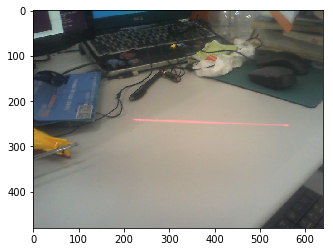

In [86]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [60]:
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

In [61]:
h, s, v = cv2.split(hsv)

In [95]:
b, g, r = cv2.split(img)

(array([19373., 47715., 33500., 19641., 17602., 42253., 99952., 25141.,
         1078.,   945.]),
 array([ 10. ,  34.5,  59. ,  83.5, 108. , 132.5, 157. , 181.5, 206. ,
        230.5, 255. ]),
 <a list of 10 Patch objects>)

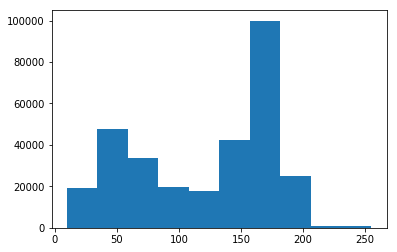

In [96]:
plt.hist(r.reshape(1, -1).squeeze())

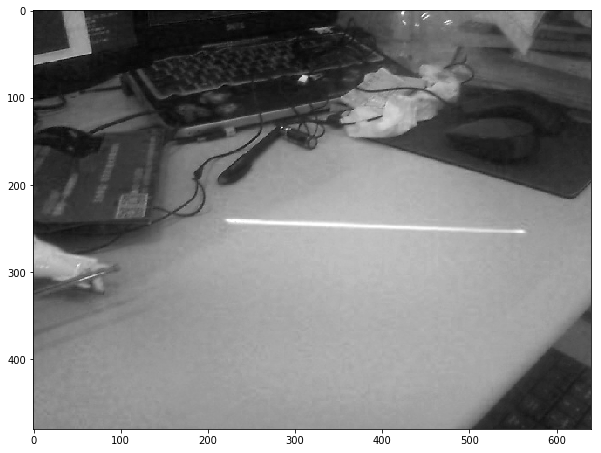

In [98]:
plt.figure(figsize=[10, 10])
plt.imshow(r, 'gray')

(array([ 53098., 122455.,  32180.,  16333.,  27491.,  31926.,  16425.,
          4530.,    829.,   1933.]),
 array([  0. ,  17.9,  35.8,  53.7,  71.6,  89.5, 107.4, 125.3, 143.2,
        161.1, 179. ]),
 <a list of 10 Patch objects>)

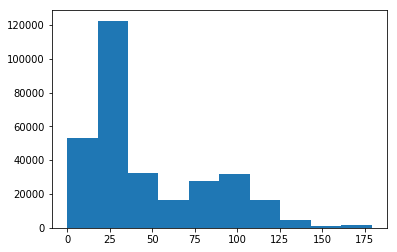

In [94]:
plt.hist(h.reshape(1, -1).squeeze())

In [91]:
s

array([[94, 91, 80, ..., 57, 63, 61],
       [87, 79, 80, ..., 55, 56, 58],
       [87, 79, 77, ..., 44, 48, 49],
       ...,
       [ 5,  9,  9, ..., 26, 16, 16],
       [ 9, 11, 11, ..., 16, 11, 16],
       [ 9, 11, 11, ..., 15, 16, 27]], dtype=uint8)

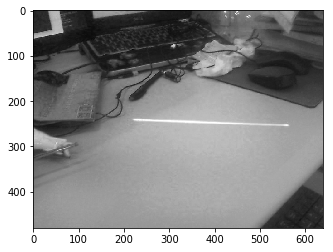

In [92]:
plt.imshow(v, 'gray')

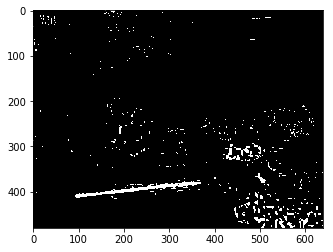

In [15]:
plt.imshow(threshold_by_range(h, 150, 180), 'gray')

(array([171201.,  44108.,  23205.,  11862.,   7453.,   6020.,   5606.,
          5482.,   8233.,  24030.]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <a list of 10 Patch objects>)

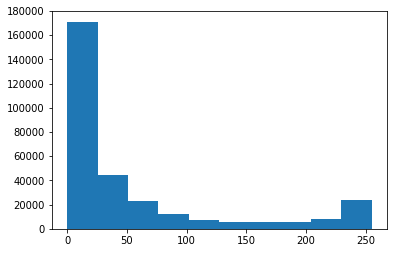

In [13]:
plt.hist(s.reshape(1, -1).squeeze())

(array([43912., 48252., 21898., 11782., 12271., 28887., 18421., 24270.,
        62889., 34618.]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <a list of 10 Patch objects>)

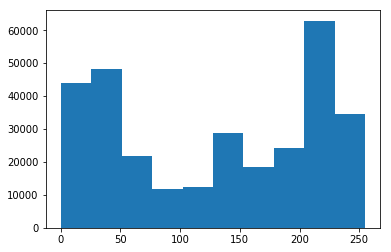

In [14]:
plt.hist(v.reshape(1, -1).squeeze())

In [109]:
center_size = 3
kernel_size = 5

h = np.arange(0, kernel_size)
w = np.arange(0, kernel_size)
hh, ww = np.meshgrid(h, w)


In [308]:
import torch
from torch import nn

class Extract_center_line_by_direction_template:
    def __init__(self, kernel_size, center_size, is_cuda=False, requires_grad=False):
        assert isinstance(kernel_size, int)
        assert isinstance(center_size, int)
        assert kernel_size >= (center_size+2)
        assert (kernel_size % 2 == 1)
        assert (center_size % 2 == 1)

        self.ks = kernel_size
        self.cs = center_size
        self.requires_grad = requires_grad
        self.is_cuda = is_cuda
        
        self.init_kernal()
    
    def __call__(self, img):
        img_pre = self.preprocessing(img).reshape(1, 1, img.shape[0], img.shape[1])
        tensor_in = torch.from_numpy(img_pre).reshape(1, 1, img.shape[0], img.shape[1]).type(torch.float)
        if self.is_cuda:
            tensor_in = tensor_in.cuda()
        
        out = nn.functional.conv2d(tensor_in, self.kernel, padding=((self.ks-1)/2, (self.ks-1)/2))
        out = out.squeeze(0)
        maxval, _ = torch.max(out, dim=0, keepdim=False)
        return maxval
        
    
    def init_kernal(self):
        k1 = torch.zeros(self.ks, self.ks, dtype=torch.float, requires_grad=self.requires_grad)
        k2 = torch.zeros(self.ks, self.ks, dtype=torch.float, requires_grad=self.requires_grad)
        
        # k1, k2
        index = int((self.ks-self.cs)/2)        
        k1[:, index:-index] = 1
        k2[index:-index, :] = 1
        
        # k3, k4
        half_center_size = (self.cs-1)/2
        h = np.arange(0, self.ks)
        w = np.arange(0, self.ks)
        ww, hh = np.meshgrid(h, w)
        
        k3_np = np.zeros((self.ks, self.ks), dtype=np.float32)
        k4_np = np.zeros((self.ks, self.ks), dtype=np.float32)
        
        index = ((ww-hh)<=half_center_size)&((ww-hh)>=-half_center_size)
        k3_np[index] = 1
        index = ((ww+hh)<=(self.ks+half_center_size-1))&((ww+hh)>=(self.ks-half_center_size-1))
        k4_np[index] = 1
        
        k3 = torch.from_numpy(k3_np)
        k4 = torch.from_numpy(k4_np)
                
        self.kernel = [k1, k2, k3, k4]
        self.kernel = [(k*torch.sum(k)/(self.ks*self.ks)).reshape(1, 1, self.ks, self.ks) for k in self.kernel]
        self.kernel = torch.cat(self.kernel, dim=0)/(self.ks*self.ks)
        if self.is_cuda:
            self.kernel = self.kernel.cuda()
    
    def preprocessing(self, img):
        b, g, r = cv2.split(img)
        return r

In [191]:
t = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3)

In [ ]:
conv2d()

In [219]:
h, w = r.shape

In [220]:
h, w

(480, 640)

In [227]:
detector.kernel.shape

torch.Size([4, 1, 11, 11])

In [239]:
img_pre = r
ks = 11
out = nn.functional.conv2d(torch.from_numpy(img_pre).reshape(1, 1, h, w).type(torch.float), detector.kernel, padding=(5, 5))

In [240]:
out.shape

torch.Size([1, 4, 480, 640])

In [241]:
(kernel_size-1)/2, (kernel_size-1)/2

(2.0, 2.0)

In [196]:
help(nn.functional.conv2d)

Help on built-in function conv2d:

conv2d(...)
    conv2d(input, weight, bias=None, stride=1, padding=0, dilation=1, groups=1) -> Tensor
    
    Applies a 2D convolution over an input image composed of several input
    planes.
    
    See :class:`~torch.nn.Conv2d` for details and output shape.
    
    Args:
        input: input tensor of shape (:math:`minibatch \times in\_channels \times iH \times iW`)
        weight: filters of shape (:math:`out\_channels \times \frac{in\_channels}{groups} \times kH \times kW`)
        bias: optional bias tensor of shape (:math:`out\_channels`). Default: ``None``
        stride: the stride of the convolving kernel. Can be a single number or a
          tuple `(sH, sW)`. Default: 1
        padding: implicit zero paddings on both sides of the input. Can be a
          single number or a tuple `(padH, padW)`. Default: 0
        dilation: the spacing between kernel elements. Can be a single number or
          a tuple `(dH, dW)`. Default: 1
        gr

In [279]:
detector = Extract_center_line_by_direction_template(11, 5)

In [292]:
out = detector(img)

out.shape

test = out.cpu().numpy()

plt.imshow((test).astype(np.uint8), 'gray')

In [272]:
out.max()

tensor(50.6236)

In [273]:
out.min()

tensor(2.3967)

In [257]:
out.shape

torch.Size([1, 480, 640])

In [258]:
out.max()

tensor(6125.4570)

In [259]:
out.min()

tensor(290.0000)

In [212]:
detector.kernel.shape

torch.Size([4, 1, 11, 11])

In [182]:
torch.sum(detector.k4)

tensor(49.)

In [103]:
torch.Tensor([[1, 2]]).shape

torch.Size([1, 2])